In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter, median_filter
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import silhouette_score, davies_bouldin_score
from itertools import cycle, islice

from scipy.signal import peak_prominences, find_peaks

from scipy.signal import savgol_filter

import sys
import time
import warnings


def savgol_svn_filter(band):
    #second_derivative = savgol_filter(band, 3, 2, deriv=2)
    svn_var = (band-band.mean())/band.std()
    smooth_final = savgol_filter(svn_var, 5, 2)
    return svn_var

#spectra pretreatment

def pre_process_svn(defined_roi):
    nd_derivative_svn_spectrs = []

    for r in range(defined_roi.shape[0]):
        for c in range(defined_roi.shape[1]):
            nd_derivative_svn_spectrs.append(savgol_svn_filter(defined_roi[r, c, :]))

    nd_derivative_svn_hypercube = np.stack(nd_derivative_svn_spectrs).reshape(defined_roi.shape[0], defined_roi.shape[1], defined_roi.shape[2])
    return nd_derivative_svn_hypercube


def pre_process_unfold_smooth(roi_snv):
    dims = roi_snv.shape[2]
    unfold_loop = []
    for i in range(dims):
        unfold_loop.append(roi_snv[:,:,i].flatten()) #(90000) for each band
    unfold_loop_array = np.stack(unfold_loop, axis=0) # (288, 90000)
    #unfold_loop_array = roi_snv.reshape(300*300, bands).T # (288, 90000)

    # Scale transposed data
    # Scale along the wavelenght axis - aka SVN pre-treatment
    unfold_loop_array_T = unfold_loop_array.T
    scaler = StandardScaler(with_mean = True, with_std=False)
    scaler.fit(unfold_loop_array_T)
    unfold_pre_t = scaler.transform(unfold_loop_array_T) # (90000, 288)
    unfold_smooth_loop = []
    for i in range(unfold_pre_t.shape[0]):
        unfold_smooth_loop.append(savgol_filter(unfold_pre_t[i,:], 10, 2))
    unfold_t = np.stack(unfold_smooth_loop, axis=0)
#unfold_t = unfold_loop_array_T
    return unfold_t


def pca_model(unfold_data, n_pc=4, n_clusters=3, model=0):
    if model == 0:
        pca_model = PCA(n_components=n_pc)
        transformed_data = pca_model.fit_transform(unfold_data)
        #gm = GaussianMixture(n_components=n_clusters, covariance_type="full").fit(transformed_data)
    else:
        pca_model = SparsePCA(n_components=n_pc, alpha=0.8)
        transformed_data = pca_model.fit_transform(unfold_data)
        #gm = GaussianMixture(n_components=n_clusters, covariance_type="full").fit(transformed_data)
    return [transformed_data, pca_model]


In [2]:

####################################
#           LOAD THE DATA          #
####################################

path = "data_in/"

file_name = path + 'XRAY_Dry_A.raw'
ref_dark = path + 'DARKREF_XRAY_Dry_A.raw'
ref_white = path + 'WHITEREF_XRAY_Dry_A.raw'

# save_preprocessed_data_to = path + "preprocessed_data.npy"

        
samples = 384
bands = 288
frames = 619

# Load the data
data_set = np.fromfile(file_name, dtype='uint16')
data_set_reform = data_set.reshape(frames, bands, samples)
data_set_reform_transpose = data_set_reform.transpose(0,2,1)

# Load the calibration data
dark = np.fromfile(ref_dark, dtype='uint16').reshape(25, bands, samples)
dark = dark.transpose(0,2,1)
dark_mean_per_band_and_sample = np.mean(dark, axis = (0))
dark_calib = dark_mean_per_band_and_sample

white = np.fromfile(ref_white, dtype='uint16').reshape(27, bands, samples)
white = white.transpose(0,2,1)
white_mean_per_band_and_sample = np.mean(white, axis = (0))
white_calib = white_mean_per_band_and_sample


# Calculate the wavelengths used
wavelengths_full = np.linspace(950, 2550, bands)
wavelengths = np.linspace(950, 2550, bands)[10:260]



####################################
#        PROCESS THE DATA          #
####################################

# Normalize intensity using the calibration data
intensisty_data = np.divide(np.subtract(data_set_reform_transpose, dark_calib), 
    np.subtract(white_calib, dark_calib))

# Calculate absorbance
absorbance_data = -np.log10(intensisty_data)

# Set the undefined values to the maximum value in the data
print("Number of undefined values:"  + str(np.sum(np.isnan(absorbance_data))))
absorbance_data[np.isnan(absorbance_data)] = np.nanmax(absorbance_data)

# Filter using a median filter
filter_size = (3,3,3)
filtered_abs_data = median_filter(absorbance_data, size=filter_size)

# Save the data for faster loading if you want
# np.save(save_preprocessed_data_to, filtered_abs_data)

C:\Users\daniil\AppData\Local\Temp\ipykernel_17456\3326729170.py:50: RuntimeWarning: divide by zero encountered in log10
  absorbance_data = -np.log10(intensisty_data)
C:\Users\daniil\AppData\Local\Temp\ipykernel_17456\3326729170.py:50: RuntimeWarning: invalid value encountered in log10
  absorbance_data = -np.log10(intensisty_data)


Number of undefined values:7207


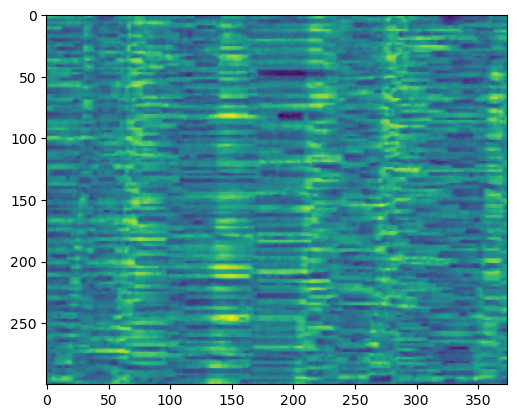

In [3]:
#Define ROI

viable_region_abs = filtered_abs_data[100:400, 5:-5, 10:260]

plt.imshow(viable_region_abs[:, :, 100])
plt.show()


Functions bellow perform the transofmration of the data according to the functions defined in the first cell.

In [4]:
nd_derivative_svn_hypercube = pre_process_svn(viable_region_abs)
unfold_t = pre_process_unfold_smooth(nd_derivative_svn_hypercube)
refold_viable_region = unfold_t.reshape(viable_region_abs.shape[0],viable_region_abs.shape[1],viable_region_abs.shape[2])


In [22]:
unfold_t.shape

(112200, 250)

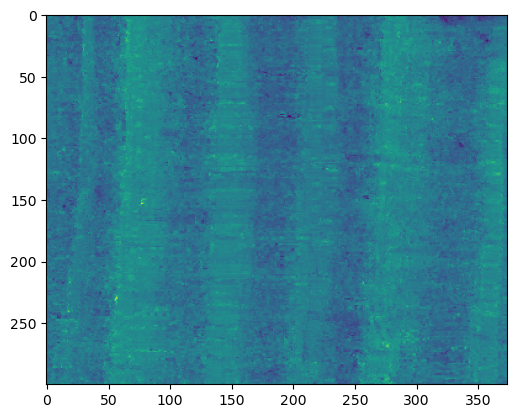

In [6]:
plt.imshow(refold_viable_region[:, :, 90])
plt.show()

Here I defined the section (150x150x250) of the hyper-image for PCA analysis.

In [102]:
analysis_roi = refold_viable_region[10:160, 10:160, :]


Applying [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [Sparce PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html) algorithms to the unfolded (XY * I) ROI.

In [93]:
pca, sparse_pca = pca_model(analysis_roi_unfolded), pca_model(analysis_roi_unfolded, model=1)
x, y, z = analysis_roi.shape[0],analysis_roi.shape[1],analysis_roi.shape[2]

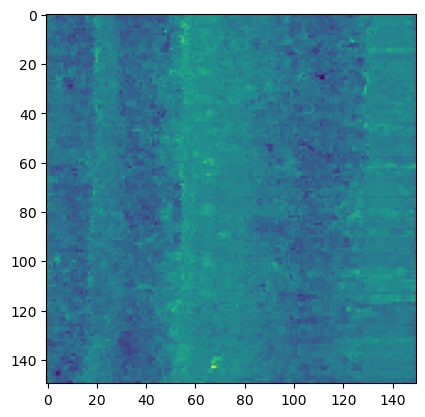

In [101]:
plt.imshow(analysis_roi_unfolded.reshape(x, y, z)[:, :, 90])
plt.show()

Eventhoug the 'elbow' is at 2 PCs, taking more PC does make sense for the chemometric application of PCA<br>
since the chemical constituents of interest can be in small proportions.

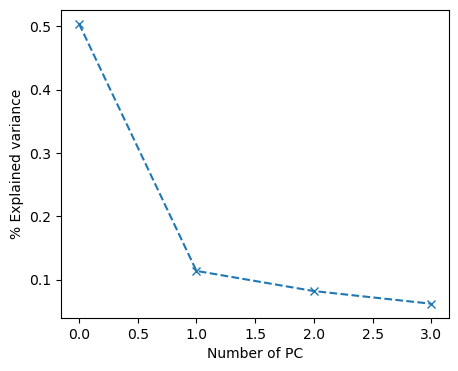

In [97]:
plt.figure(figsize=(5,4 ))
plt.plot(mean_pca.explained_variance_ratio_, '--x')
plt.ylabel('% Explained variance')
plt.xlabel('Number of PC')
plt.show()

In [99]:
n_clusters = 3
gm_sparce = GaussianMixture(n_components=n_clusters, covariance_type="full").fit(sparse_pca[0])
gm_pca = GaussianMixture(n_components=n_clusters, covariance_type="full").fit(pca[0])
cluster_label_sparse = gm_sparce.predict(sparse_pca[0])
cluster_label_pca = gm_pca.predict(pca[0])

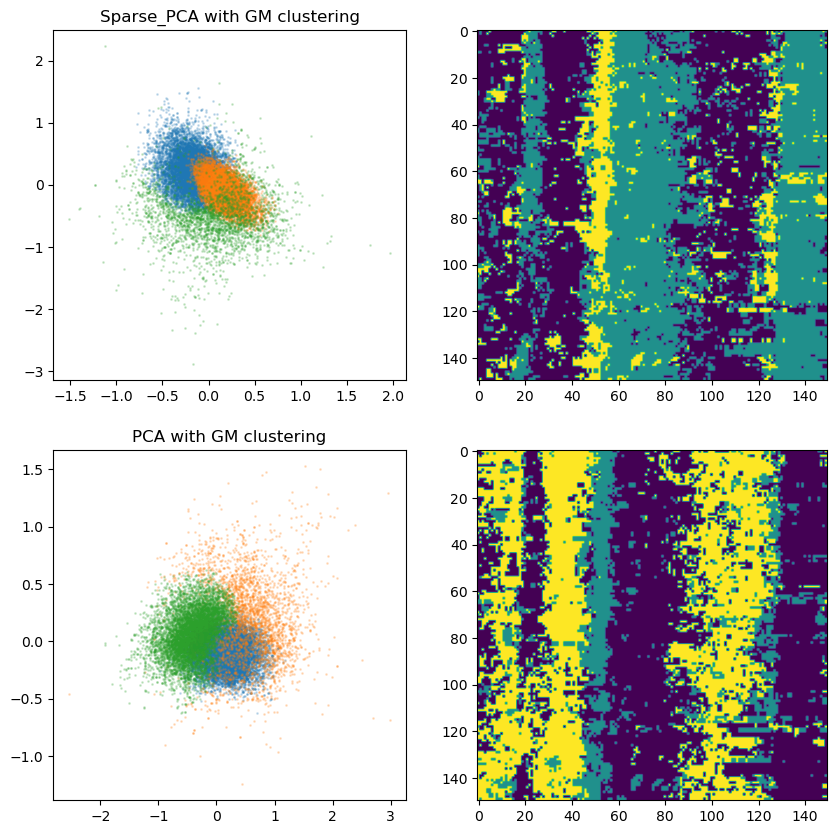

In [100]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
for i in range(n_clusters):
    ax[0,0].scatter(sparse_pca[0][cluster_label_sparse==i,0], sparse_pca[0][cluster_label_sparse==i,1], s=1, alpha=0.2)
    ax[1,0].scatter(pca[0][cluster_label_pca==i,0], pca[0][cluster_label_pca==i,1], s=1, alpha=0.2)
ax[0, 0].set_title('Sparse_PCA with GM clustering')
ax[1, 0].set_title('PCA with GM clustering')
ax[0, 1].imshow(cluster_label_sparse.reshape(analysis_roi.shape[0], analysis_roi.shape[1]))
ax[1, 1].imshow(cluster_label_pca.reshape(analysis_roi.shape[0], analysis_roi.shape[1]))
plt.show()

Bellow I applied the PCA 'model', based on the 150x150x250 hyper-image ROI presented before, on the whole hype-image to see how well it can differentiate<br>
componnents(assuming that different different PC represent different chemical components i.e. cellulose/hemicelloce, water, lignin, etc)

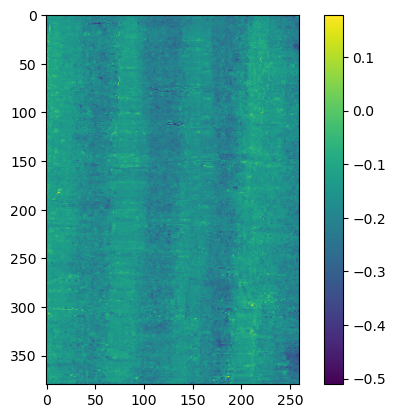

In [89]:
roi_val = filtered_abs_data[70:450, 70:330, 10:260]
nd_derivative_svn_hypercube_val = pre_process_svn(roi_val)
unfold_t_val = pre_process_unfold_smooth(nd_derivative_svn_hypercube_val)
# Here we imaging the results of the hyper-image transformation. 
ax = plt.subplot()
im = ax.imshow(nd_derivative_svn_hypercube_val[:, :, 90])
plt.colorbar(im)
plt.show()

In [57]:
#Trnasforming based on PCA model (based on ROI) and clusting in PC score space using GM model.
nir_pca_val = pca[1].transform(unfold_t_val)
nir_sparce_val = sparse_pca[1].transform(unfold_t_val)
cluster_label_sparse_val = gm_sparce.predict(nir_sparce_val)
cluster_label_pca_val = gm_pca.predict(nir_pca_val)

Bellow is the results, supposedly different color represent differnet chemical component(or rather a mixture of simillar components).

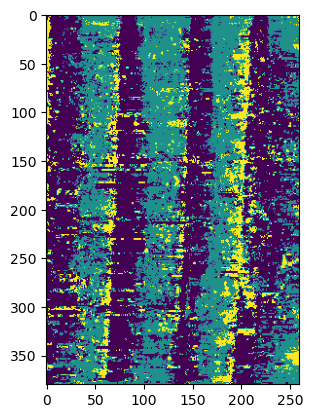

In [91]:
plt.imshow(cluster_label_pca_val.reshape(roi_val.shape[0], roi_val.shape[1]))
plt.show()

No reall practial application in this part, was interested to see how the hyper-image would look like if the PCs<br>
are represented in the RGBA format and an image is composed out of them. Looks neat.

In [54]:
from PIL import Image

rgba_list = []
for i in range(4):
    scaler = MinMaxScaler()
    reformed_ar = scaler.fit_transform(nir_pca_val[:,i].reshape(-1, 1))*255
    rgba_list.append(reformed_ar.astype('uint8'))
rgba_array = np.hstack(rgba_list)
rgba_img = rgba_array.reshape(roi_val.shape[0], roi_val.shape[1], 4)
resulting_img = Image.fromarray(rgba_img,  mode='RGBA')
resulting_img.save('rgba_img.png', 'PNG')

Visualization of loadings of PCA model.

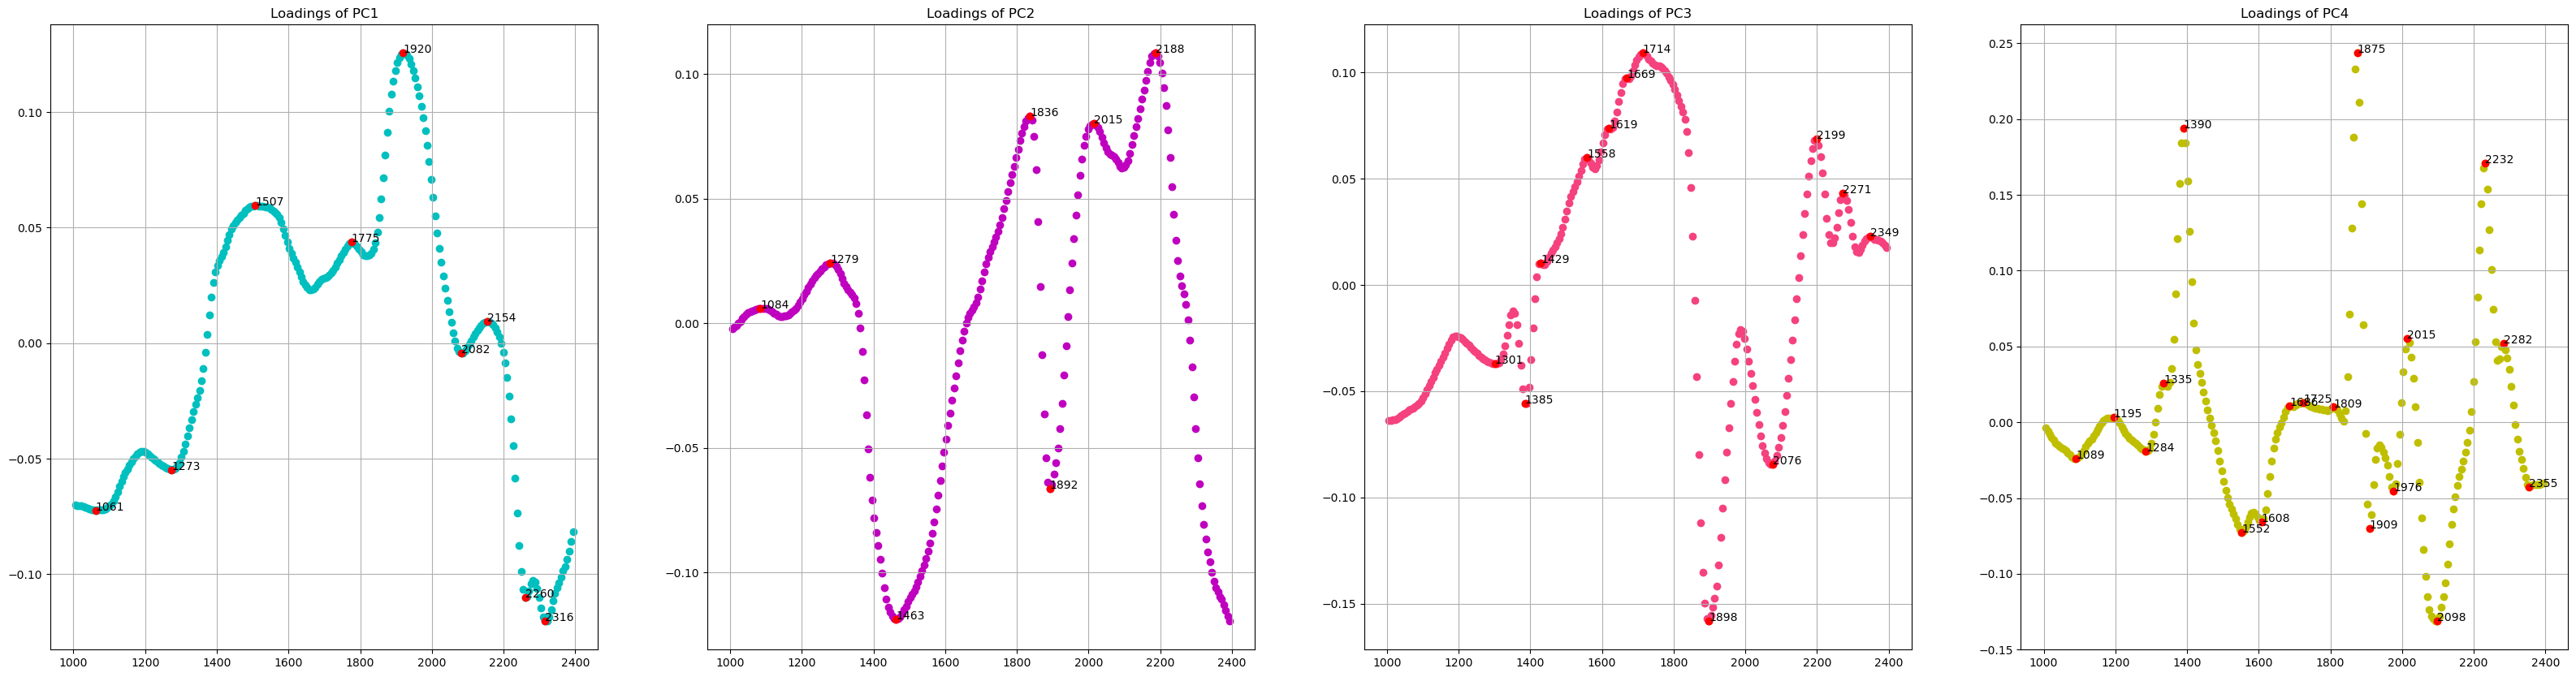

In [62]:
#plt.plot(wavelengths, x)

def visual_loadings(model_data):
    color = ['c', 'm', '#f5427e', 'y']
    names = ['PC1','PC2','PC3','PC4',]
    fig, ax = plt.subplots(1, 4, figsize=(40,10))
    for i in range(4):
        peaks, _ = find_peaks(abs(model_data[1].components_[i]), distance=5, prominence=(None, 0.5))
        ax[i].scatter(wavelengths, (model_data[1].components_[i]), alpha=1, c=color[i])
        ax[i].scatter(wavelengths[peaks], model_data[1].components_[i][peaks], c='r')
        for point in peaks:
            ax[i].annotate(round(wavelengths[point]), (wavelengths[point], model_data[1].components_[i][point]))
        ax[i].set_title(f'Loadings of {names[i]}')
    #plt.xlim(1000, 2500)
        ax[i].grid(visible=True)
    plt.savefig('contrib_big.svg')
    plt.show()

visual_loadings(pca)

Bellow is a utility function to help plot PC 'spectra' - PCA loadings, that in practice represent vaiable contribution to PC<br>
therfore loading with 

In [104]:
from scipy.signal import lfilter

def plot_2nd_main(pc_num):
    n = 5
    b = [1.0/n]*n
    a = 1

    pc = pc_num

    color=['c', 'm', 'b', 'p']

    fig, ax = plt.subplots(1,1, figsize=(10, 5))
    ax.plot(wavelengths, (abs(pca[1].components_[pc])), alpha=1, c=color[pc])
    peaks1, _ = find_peaks(abs(pca[1].components_[pc]), distance=5, prominence=(None, 0.5))
    ax.scatter(wavelengths[peaks1], abs(pca[1].components_[pc][peaks1]), c=color[pc])
    for point in peaks1:
            ax.annotate(round(wavelengths[point]), (wavelengths[point], abs(pca[1].components_[pc][point])))
    ax2 = ax.twinx()
    derivative_data = savgol_filter(abs(pca[1].components_[pc]), 3, 2, deriv=2)#*(-1)
    
    #filtered_data = lfilter(b,a,derivative_data)
    filtered_data = savgol_filter(derivative_data, 12, 3)
    ax2.plot(wavelengths, filtered_data , '--', alpha=0.5,  c=color[pc])
    peaks, _ = find_peaks(abs(filtered_data), distance=10, prominence=(None, 0.8))
    ax.scatter(wavelengths[peaks], abs(pca[1].components_[pc][peaks]), c='r', alpha=0.5)
    for txt in peaks:
        ax.annotate(round(wavelengths[txt]), (wavelengths[txt], abs(pca[1].components_[pc][txt])), alpha=0.5)
    #ax2.plot(wavelengths, lfilter(b,a,derivative_data*-1) , '--', alpha=0.5,  c=color[0])
    #ax2.plot(wavelengths, derivative_data , '--', alpha=0.5,  c=color[0])
    ax.set_title(f'PC{pc+1} Loadings and Derivative')
    ax.set_xlabel('Wavelenght, nm')
    ax.set_ylabel('Coefficient, au')
    ax2.set_ylabel('Derivative, au')
    plt.savefig(f'./github_images/pc{pc+1}_dervi_plot.svg')

The plot looks cluttered with peaks as I tried to use 2nd derivative method to uncorver peaks, since peak assignment and detection in NIR data<br>
is natoriously difficult due to presence of overtones, etc.

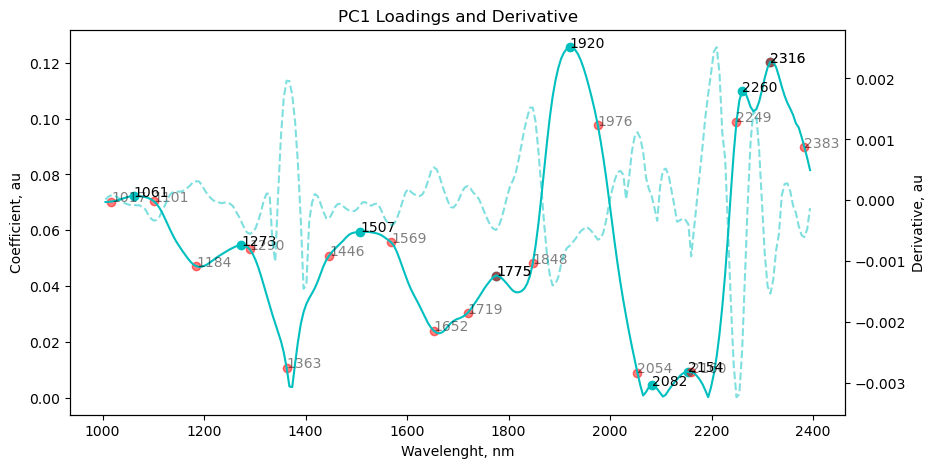

In [105]:
plot_2nd_main(0)

Playing with different peak deconvolution methods - SVN approach bellow.

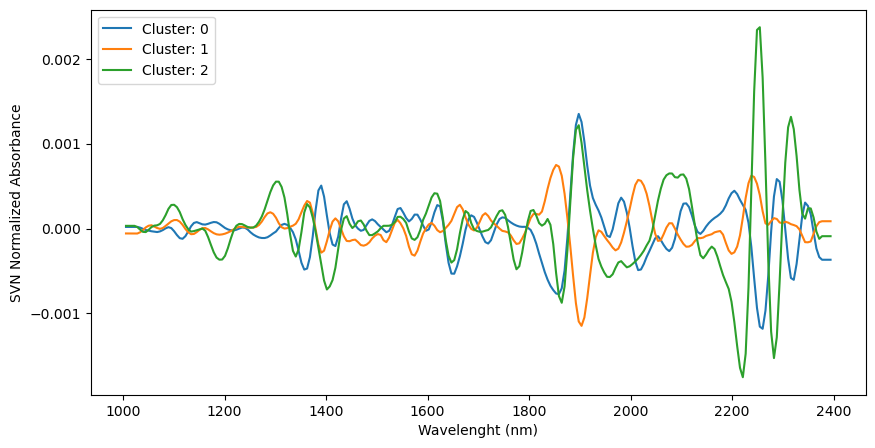

In [106]:
plt.figure(figsize=(10, 5))
for i in range(3):
    pixels_of_cluster_c = analysis_roi_unfolded[cluster_label_sparse == i,:]
    plt.plot(wavelengths,savgol_filter(pixels_of_cluster_c.mean(axis=0), 7, 2, deriv=2), label=f'Cluster: {i}')
plt.ylabel('SVN Normalized Absorbance')
plt.xlabel('Wavelenght (nm)')
plt.legend()
plt.savefig('./github_images/2nd_normalized_cluster_spec.svg')
plt.show()